In [86]:
import os
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from moviepy.editor import *
from collections import deque

In [2]:
img_height, img_width = 128, 128

In [3]:
data_dir_path = '../cali_merl_project/data/'

In [4]:
features = np.load(data_dir_path + 'features.csv.npy')
labels = np.load(data_dir_path + 'labels.npy')

**Features / Labels was preprocess through Google Colab:** <br>
- image resized to (128, 128, 3)
- Took the first 90 clips from each labels to extract frames from it.
- Randomly extract 2500 frames from each labels

In [5]:
# One Hot Encode y
ohe_labels = to_categorical(labels)

In [6]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(features, ohe_labels, test_size = 0.3, stratify = ohe_labels)

In [57]:
features.shape

(12500, 128, 128, 3)

In [68]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    model = VGG16(include_top=False, weights='imagenet',
                input_shape=(128, 128, 3)
                  )
    return model

model = load_model()

In [69]:
def set_nontrainable_layers(model):
    model.trainable=False
    return model

In [70]:
def add_last_layers(model):
    base_model = set_nontrainable_layers(model)
    flattening_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(5, activation='softmax')

    model = models.Sequential([
        base_model,
        flattening_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [76]:
def compile_model(model):
    adam_opt = optimizers.Adam(learning_rate=0.001)

    model.compile(loss='categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['accuracy'])
    return model

model = compile_model(model)

In [77]:
def build_model():
    model = load_model()
    model = add_last_layers(model)
    model = compile_model(model)

    return model

model = build_model()

In [78]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_12 (Flatten)        (None, 8192)              0         
                                                                 
 dense_33 (Dense)            (None, 500)               4096500   
                                                                 
 dense_34 (Dense)            (None, 5)                 2505      
                                                                 
Total params: 18,813,693
Trainable params: 4,099,005
Non-trainable params: 14,714,688
_________________________________________________________________


In [79]:
es = EarlyStopping(patience=5,  restore_best_weights=True)

model = build_model()

history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=25,
                    batch_size=30, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/25
205/205 [==============================] - 1035s 5s/step - loss: 0.9597 - accuracy: 0.6846 - val_loss: 0.4462 - val_accuracy: 0.8236
Epoch 2/25
205/205 [==============================] - 1037s 5s/step - loss: 0.3777 - accuracy: 0.8436 - val_loss: 0.2876 - val_accuracy: 0.8850
Epoch 3/25
205/205 [==============================] - 1037s 5s/step - loss: 0.2791 - accuracy: 0.8841 - val_loss: 0.2313 - val_accuracy: 0.9109
Epoch 4/25
205/205 [==============================] - 1036s 5s/step - loss: 0.2229 - accuracy: 0.9094 - val_loss: 0.3170 - val_accuracy: 0.8693
Epoch 5/25
205/205 [==============================] - 1230s 6s/step - loss: 0.2193 - accuracy: 0.9069 - val_loss: 0.2103 - val_accuracy: 0.9177
Epoch 6/25
205/205 [==============================] - 1234s 6s/step - loss: 0.1923 - accuracy: 0.9211 - val_loss: 0.1671 - val_accuracy: 0.9299
Epoch 7/25
205/205 [==============================] - 1238s 6s/step - loss: 0.1845 - accuracy: 0.9193 - val_loss: 0.1613 - val_accuracy:

In [80]:
#Save the model
model.save('../cali_merl_project/models/VGG16___LOSS_08___ACCURACY_97.h5')

In [81]:
model.evaluate(X_test, y_test)

118/118 [==============================] - 451s 4s/step - loss: 0.1061 - accuracy: 0.9667


[0.10607319325208664, 0.9666666388511658]

In [82]:
def plot_loss_accuracy(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

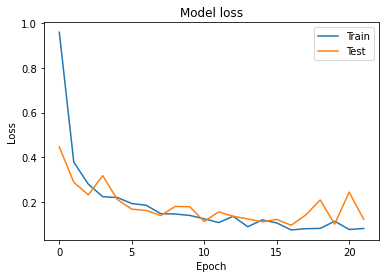

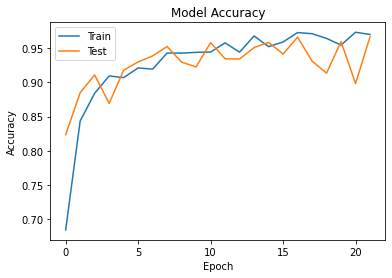

In [83]:
plot_loss_accuracy(history)

In [118]:
# Predict the label for a short clip -> Using Moving Average !
video_test = '41_2_HandinShelf_0_1597_1750'
testing_video_file_path = f'../cali_merl_project/For_Testing/{video_test}.mp4'
video_reader_pred = cv2.VideoCapture(testing_video_file_path)
total_number_frames = int(video_reader_pred.get(cv2.CAP_PROP_FRAME_COUNT))
y_pred_deque = deque(maxlen = total_number_frames)

while True: 
    status, frame = video_reader_pred.read() 

    if not status:
        break
    
    # Preprocess the frames
    resized_frame = cv2.resize(frame, (img_height, img_width))
    normalized_frame = resized_frame / 255

    y_pred = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
    y_pred_deque.append(y_pred)

    # Average the proba for the whole clip !
    if len(y_pred_deque) == total_number_frames:

        # Deque
        y_pred_np = np.array(y_pred_deque)
        y_pred_averaged = y_pred_np.mean(axis = 0)
        predicted_label = np.argmax(y_pred_averaged)

        predicted_label_name = labels_list[predicted_label]
        predict_proba = y_pred_averaged[predicted_label]
        text_2_plot = f'{str(predicted_label_name)} - {str(round(predict_proba*100,2))} %'
        print(text_2_plot)

Hand_in_Shelf - 90.09 %


In [121]:
# Predict the label & plot the predicted_label + predicted_proba directly on the frames
def action_predict(video_file_path, output_file_path, window_size):

    y_pred_deque = deque(maxlen = window_size)
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 30, (original_video_width, original_video_height))

    while True: 
        status, frame = video_reader.read() 

        if not status:
            break

        # Preprocess the frames
        resized_frame = cv2.resize(frame, (img_height, img_width))
        normalized_frame = resized_frame / 255

        y_pred = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
        y_pred_deque.append(y_pred)

        # Average the proba for the whole clip !
        if len(y_pred_deque) == window_size:

            # Deque
            y_pred_np = np.array(y_pred_deque)
            y_pred_averaged = y_pred_np.mean(axis = 0)
            predicted_label = np.argmax(y_pred_averaged)

            predicted_label_name = labels_list[predicted_label]
            predict_proba = y_pred_averaged[predicted_label]
            text_2_plot = f'{str(predicted_label_name)} - {str(round(predict_proba*100,2))} %'
          
            # Add Label on top of the clips
            x,y,w,h = 0,0,350,70
            cv2.rectangle(frame, (x, x), (x + w, y + h), (0,0,128), -1)
            cv2.putText(frame, text_2_plot, (30, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

        video_writer.write(frame)

        # Do not uncomment line below otherwise JupyterNotebook Crash is coming !
        # cv2.imshow('Predicted Frames', frame)
        # key_pressed = cv2.waitKey(10)
        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [123]:
window_size = 30  # <- Allow to avoid frame by frame prediction - Mean the prediction for the last 30 frames 
video_title = '41_2_crop'
input_video_file_path = f'../cali_merl_project/For_Testing/{video_title}.mp4'
output_video_file_path = f'../cali_merl_project/predicted_vids/BestModel_MovingAverage_{video_title}_predicted.mp4'

action_predict(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
# Comment if the video is too heavy for Notebook
#VideoFileClip(output_video_file_path).ipython_display(width = 700)

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
